In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import zscore
import os
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure7/output_fig7/'

from scripts.io_library import MyLib
from scripts.utils import Utils
from scripts.visualization import MyVisualization
from scripts.clustering_utils import Clustering
from scripts.invoking_R_functions import MyRFunctions

In [2]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

In [3]:
data_dir = ''
gene_effect_file = 'Main_Data/CRISPR/CRISPR.csv'
gene_effect_df = MyLib.load_csv(gene_effect_file, index_col=0)
gene_effect_df = gene_effect_df.T

genes_exclude_file = 'Additional_Data/Selected_Lists/all_common_genes.csv'
genes_exclude = MyLib.load_csv(genes_exclude_file)['Gene'].tolist()
gene_effect_df = gene_effect_df.loc[:, ~gene_effect_df.columns.isin(genes_exclude)]

upset_file = 'cell_lines_master_upset_2025-2-24.csv'
raw_upset_df = MyLib.load_csv(upset_file, index_col=0)
upset_df = raw_upset_df[(raw_upset_df['CRISPR']==1) & (raw_upset_df['Subtype'] != 'HCC')]
upset_df = upset_df[["Subtype"]]

gene_effect_df = gene_effect_df.loc[upset_df.index]

top_mut_file = 'Additional_Data/Selected_Lists/heatmap_top_alterations.csv'
top_mut_df = MyLib.load_csv(top_mut_file, index_col=0)
top_mut_df = top_mut_df.rename(columns={c:f'{c}$' for c in top_mut_df.columns.tolist()})
top_mut_df = top_mut_df[["FGFR2$","BAP1$", "IDH1/2$","BRAF$","SMAD4$", "KRAS$", "TP53$" ]]
# upset_mut_df = pd.concat([upset_df, top_mut_df.loc[upset_df.index, :]], axis=1)

rna_upset_file = 'Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv'
rna_upset_df = pd.read_csv(rna_upset_file, index_col=0)
protein_upset_file = 'Figure6/output_fig6/Protein_reordered_upset_df.csv'
protein_upset_df = pd.read_csv(protein_upset_file, index_col=0)
shared_lines = sorted(set(rna_upset_df.index).intersection(set(protein_upset_df.index)))
rna_protein_upset_df = rna_upset_df[['Subtype']]
rna_protein_upset_df.loc[shared_lines, 'Protein_Cluster'] = protein_upset_df.loc[shared_lines, 'Cluster']
rna_protein_upset_df[['RNA_Cluster']] = rna_upset_df[['RNA_Cluster']]
# df = pd.concat([upset_mut_df, rna_protein_upset_df[['RNA_Cluster', 'Protein_Cluster']]], axis=1)
df = pd.concat([upset_df, rna_protein_upset_df[['RNA_Cluster', 'Protein_Cluster']], top_mut_df.loc[upset_df.index, :]], axis=1)
upset_mut_df = df.loc[upset_df.index]

input_data/Main_Data/CRISPR/CRISPR.csv  is loaded, shape:  (18443, 60)

input_data/Additional_Data/Selected_Lists/all_common_genes.csv  is loaded, shape:  (2577, 1)

input_data/cell_lines_master_upset_2025-2-24.csv  is loaded, shape:  (87, 11)

input_data/Additional_Data/Selected_Lists/heatmap_top_alterations.csv  is loaded, shape:  (87, 12)



In [4]:
upset_mut_df

,Subtype,RNA_Cluster,Protein_Cluster,FGFR2$,BAP1$,IDH1/2$,BRAF$,SMAD4$,KRAS$,TP53$
Cell_line,,,,,,,,,,
SNU869,AC,R4,P5,NaN,NaN,NaN,NaN,MISSENSE,MISSENSE,NaN
SNU478,AC,R4,P5,NaN,NaN,NaN,NaN,NaN,NaN,FRAME_SHIFT_INS
TGBC52TKB,AC,R1,P3,NaN,NaN,NaN,NaN,NaN,MISSENSE,NaN
AOVC1,AC,R4,P5,NaN,NaN,NaN,NaN,NaN,NaN,NONSENSE
TGBC18TKB,AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MISSENSE
SNU1196,ECC,R4,P5,NaN,NaN,NaN,NaN,NONSENSE,NaN,MISSENSE
EGI1,ECC,R4,P3,NaN,NaN,NaN,NaN,NaN,MISSENSE,MISSENSE
KKU100,ECC,R1,P3,NaN,NaN,NaN,NaN,SPLICE_SITE,MISSENSE,NaN
TFK1,ECC,R4,P3,NaN,NONSENSE,NaN,NaN,NaN,NaN,NONSENSE


# normLRT across BTC cell lines

In [5]:
lrt_file = 'Additional_Data/Selected_Lists/lrt_table.csv'
lrt_df = MyLib.load_csv(lrt_file)
lrt_df = lrt_df[lrt_df['skewed_left']]
lrt_df.reset_index(inplace=True, drop=True)
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.split('..')[0]+' ('+x.split('..')[1]+')').apply(lambda x:x.replace('.)', ')'))
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.replace('.', '-'))
lrt_df['name'] = lrt_df['gene'].apply(lambda x:x.split()[0])


input_data/Additional_Data/Selected_Lists/lrt_table.csv  is loaded, shape:  (18443, 5)



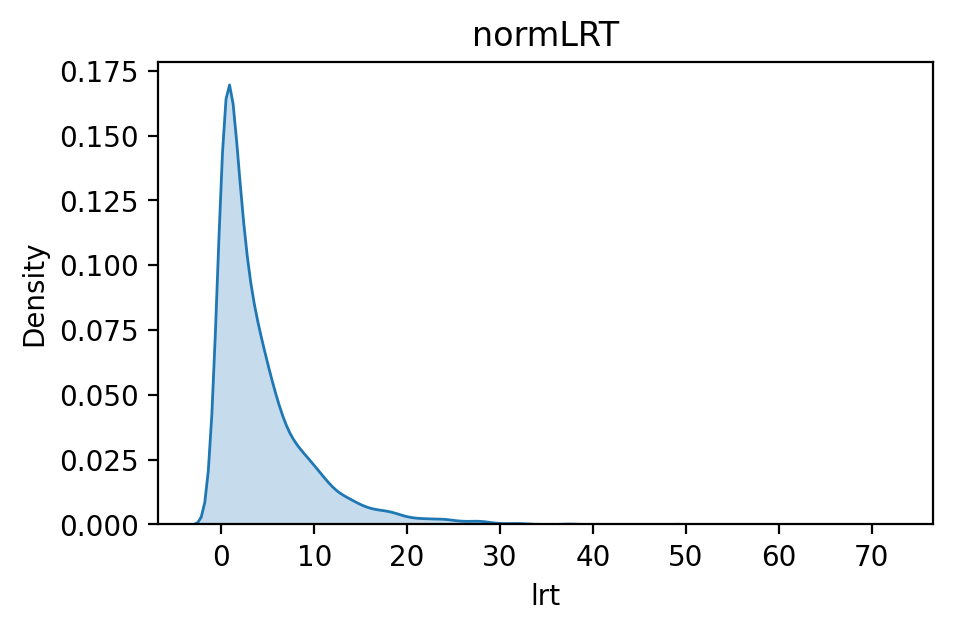

In [6]:
MyVisualization.plot_distribution(lrt_df['lrt'], 'normLRT')

## Clustering of the most variable outlier dependencies

In [7]:
gene_effect_filtered_df = Clustering.select_variable_features(gene_effect_df.dropna(axis=1), variance_percentile_cutoff=85)

threshold = np.percentile(lrt_df['lrt'].dropna(), 90)
genes_l = [g for g in lrt_df[lrt_df['lrt']> round(threshold)]['gene'].tolist() if g in gene_effect_df.columns]

selected_genes_l = list(set(genes_l).intersection(gene_effect_filtered_df.columns))
gene_effect_lrt_filtered_df = gene_effect_filtered_df[selected_genes_l]
corr_gene_effect_lrt_filtered_df = pd.DataFrame(np.corrcoef(gene_effect_lrt_filtered_df.values),
columns=gene_effect_lrt_filtered_df.index, index=gene_effect_lrt_filtered_df.index)
gene_effect_lrt_filtered_df = gene_effect_lrt_filtered_df.rename(columns={col:col.split(' (')[0] for col in gene_effect_lrt_filtered_df.columns})
gene_effect_lrt_filtered_df.shape


(39, 417)

In [8]:
volcano_axes_lim_dic={'D1':(5,0,1,None,None,1), 'D2':(5,0,2,None,None,2), 'D3':(5,0,1,None,None,1), 'D4':(5,0,1,None,None,1), 'D5':(5,0,1,None,None,1), 'D6':(5,0,1,None,None,1)}


File  Figure7/output_fig7/all_D1_features_Down.csv saved, shape: (61, 6)


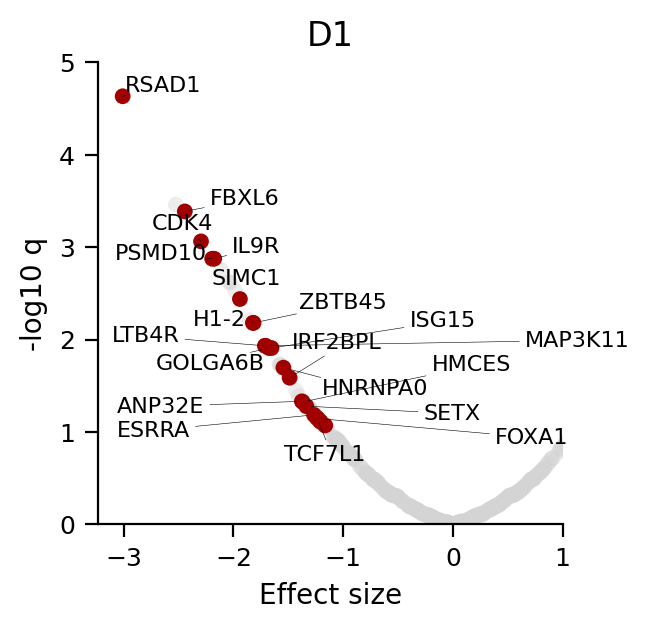


File  Figure7/output_fig7/D1_features_Down_dep_hits.csv saved, shape: (23, 5)

File  Figure7/output_fig7/D1_features_Down.csv saved, shape: (61, 5)

File  Figure7/output_fig7/all_D2_features_Down.csv saved, shape: (5, 6)


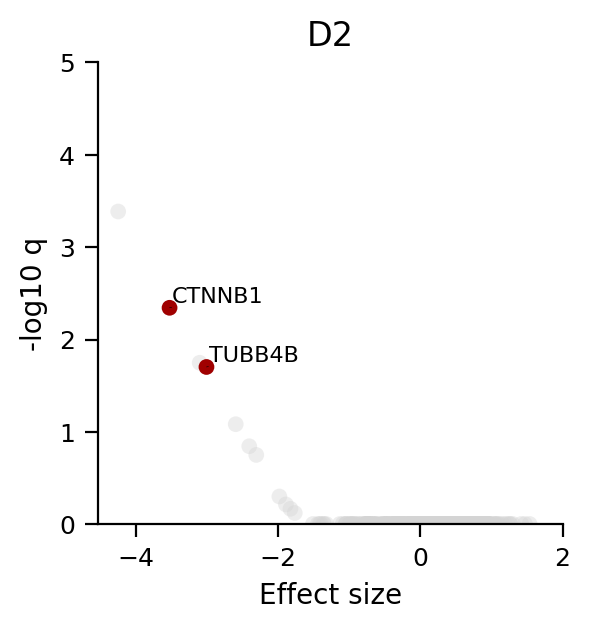


File  Figure7/output_fig7/D2_features_Down_dep_hits.csv saved, shape: (2, 5)

File  Figure7/output_fig7/D2_features_Down.csv saved, shape: (5, 5)

File  Figure7/output_fig7/all_D3_features_Down.csv saved, shape: (9, 6)


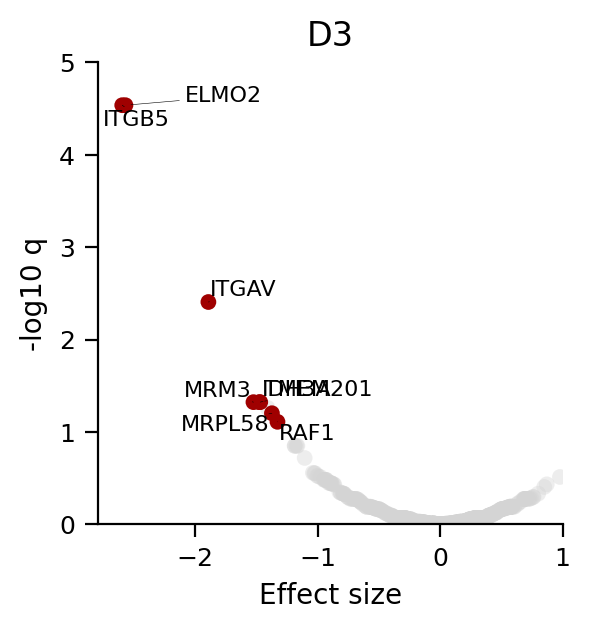


File  Figure7/output_fig7/D3_features_Down_dep_hits.csv saved, shape: (8, 5)

File  Figure7/output_fig7/D3_features_Down.csv saved, shape: (9, 5)

File  Figure7/output_fig7/all_D4_features_Down.csv saved, shape: (13, 6)


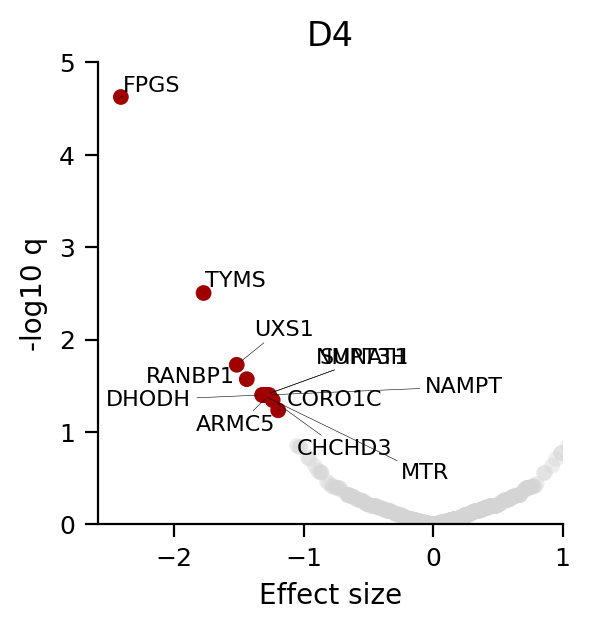


File  Figure7/output_fig7/D4_features_Down_dep_hits.csv saved, shape: (12, 5)

File  Figure7/output_fig7/D4_features_Down.csv saved, shape: (13, 5)

File  Figure7/output_fig7/all_D5_features_Down.csv saved, shape: (16, 6)


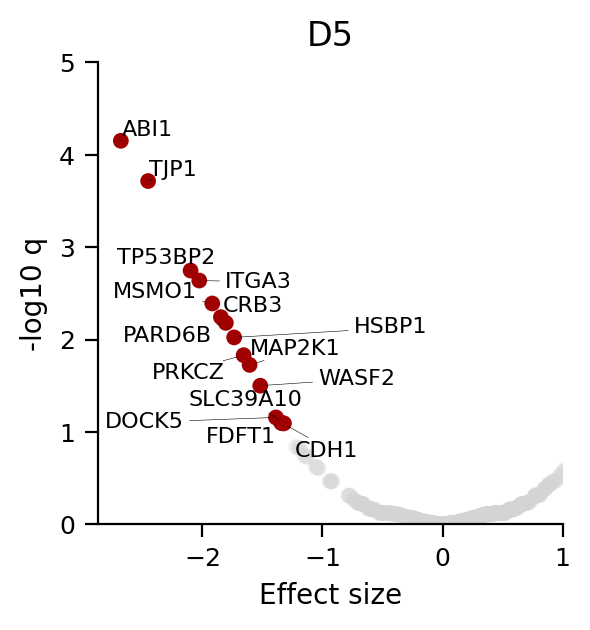


File  Figure7/output_fig7/D5_features_Down_dep_hits.csv saved, shape: (15, 5)

File  Figure7/output_fig7/D5_features_Down.csv saved, shape: (16, 5)

File  Figure7/output_fig7/all_D6_features_Down.csv saved, shape: (2, 6)


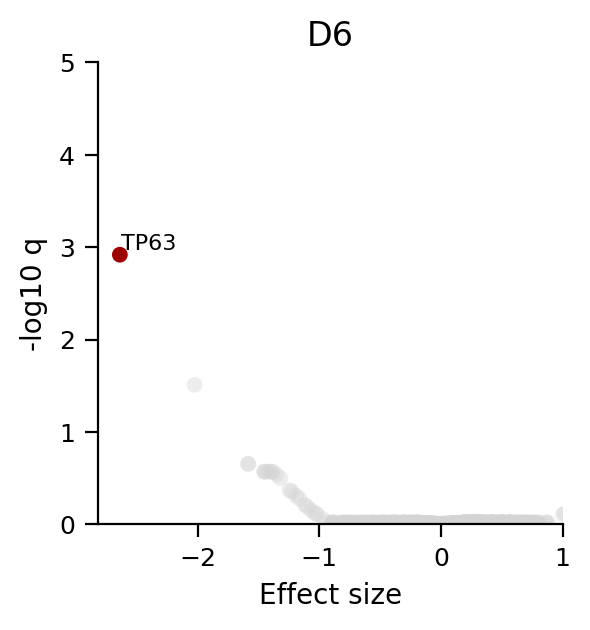


File  Figure7/output_fig7/D6_features_Down_dep_hits.csv saved, shape: (1, 5)

File  Figure7/output_fig7/D6_features_Down.csv saved, shape: (2, 5)

File  Figure7/output_fig7/LRT_Gene_reordered_upset_df.csv saved, shape: (39, 4)


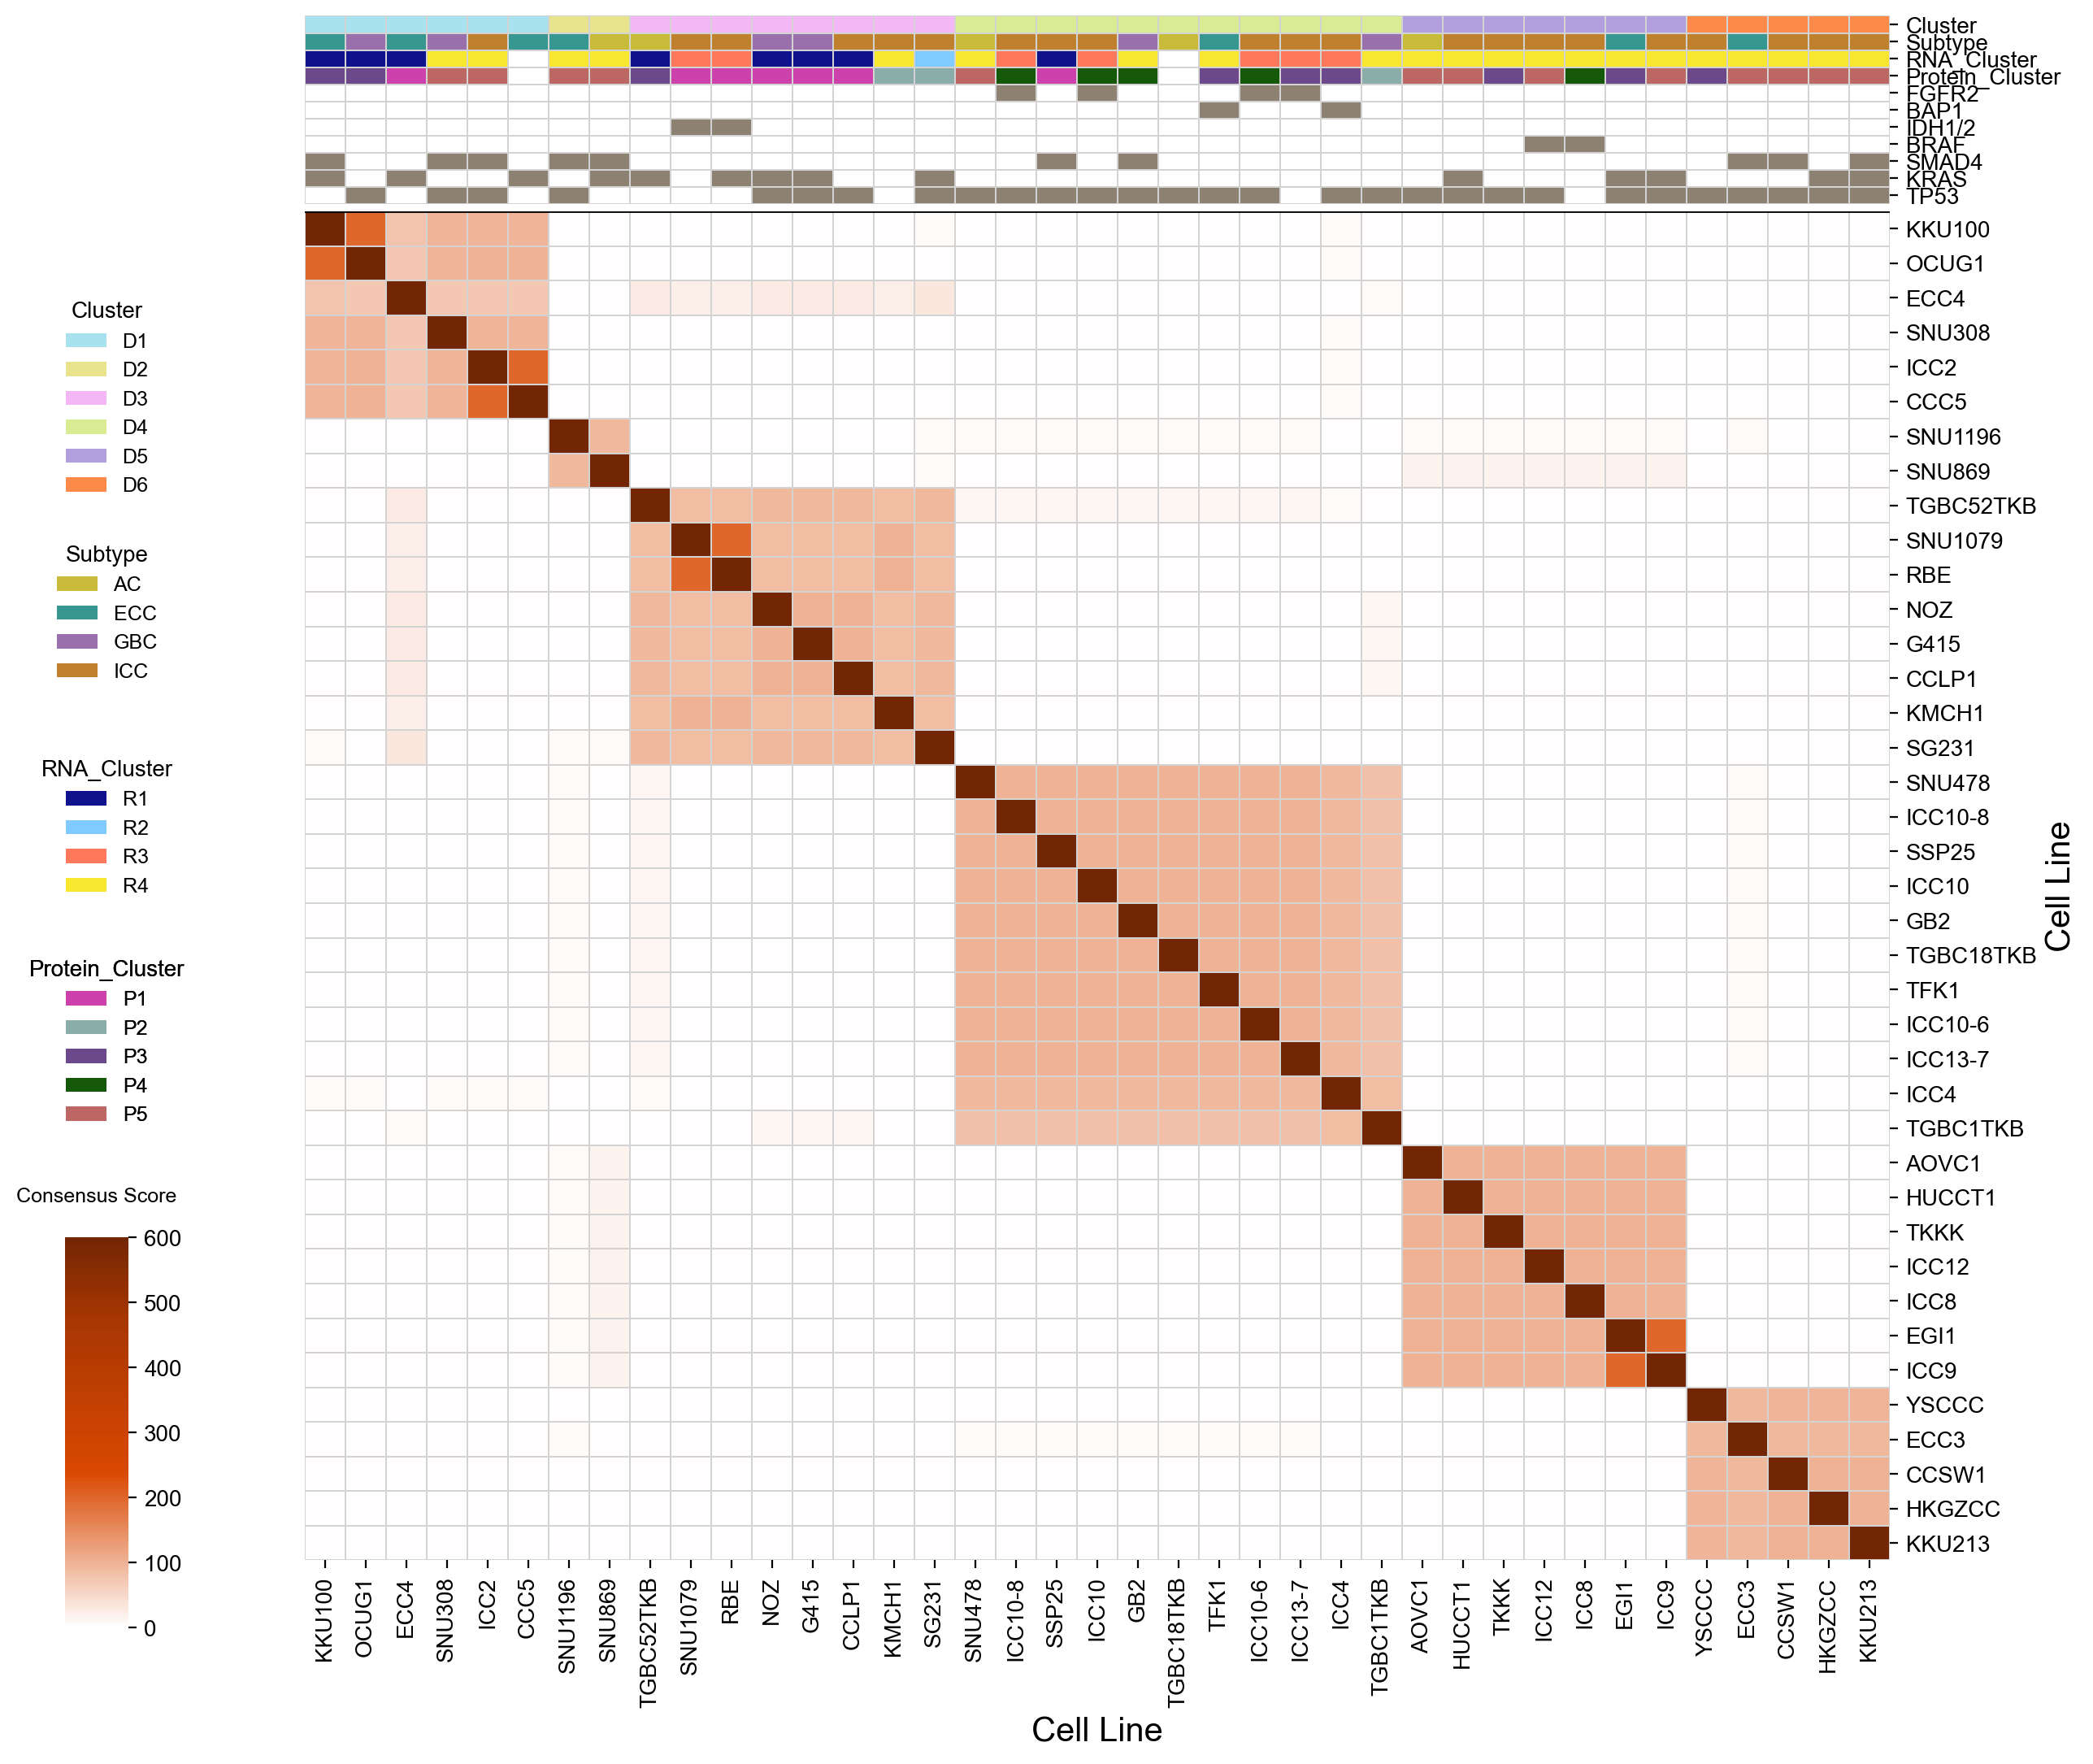

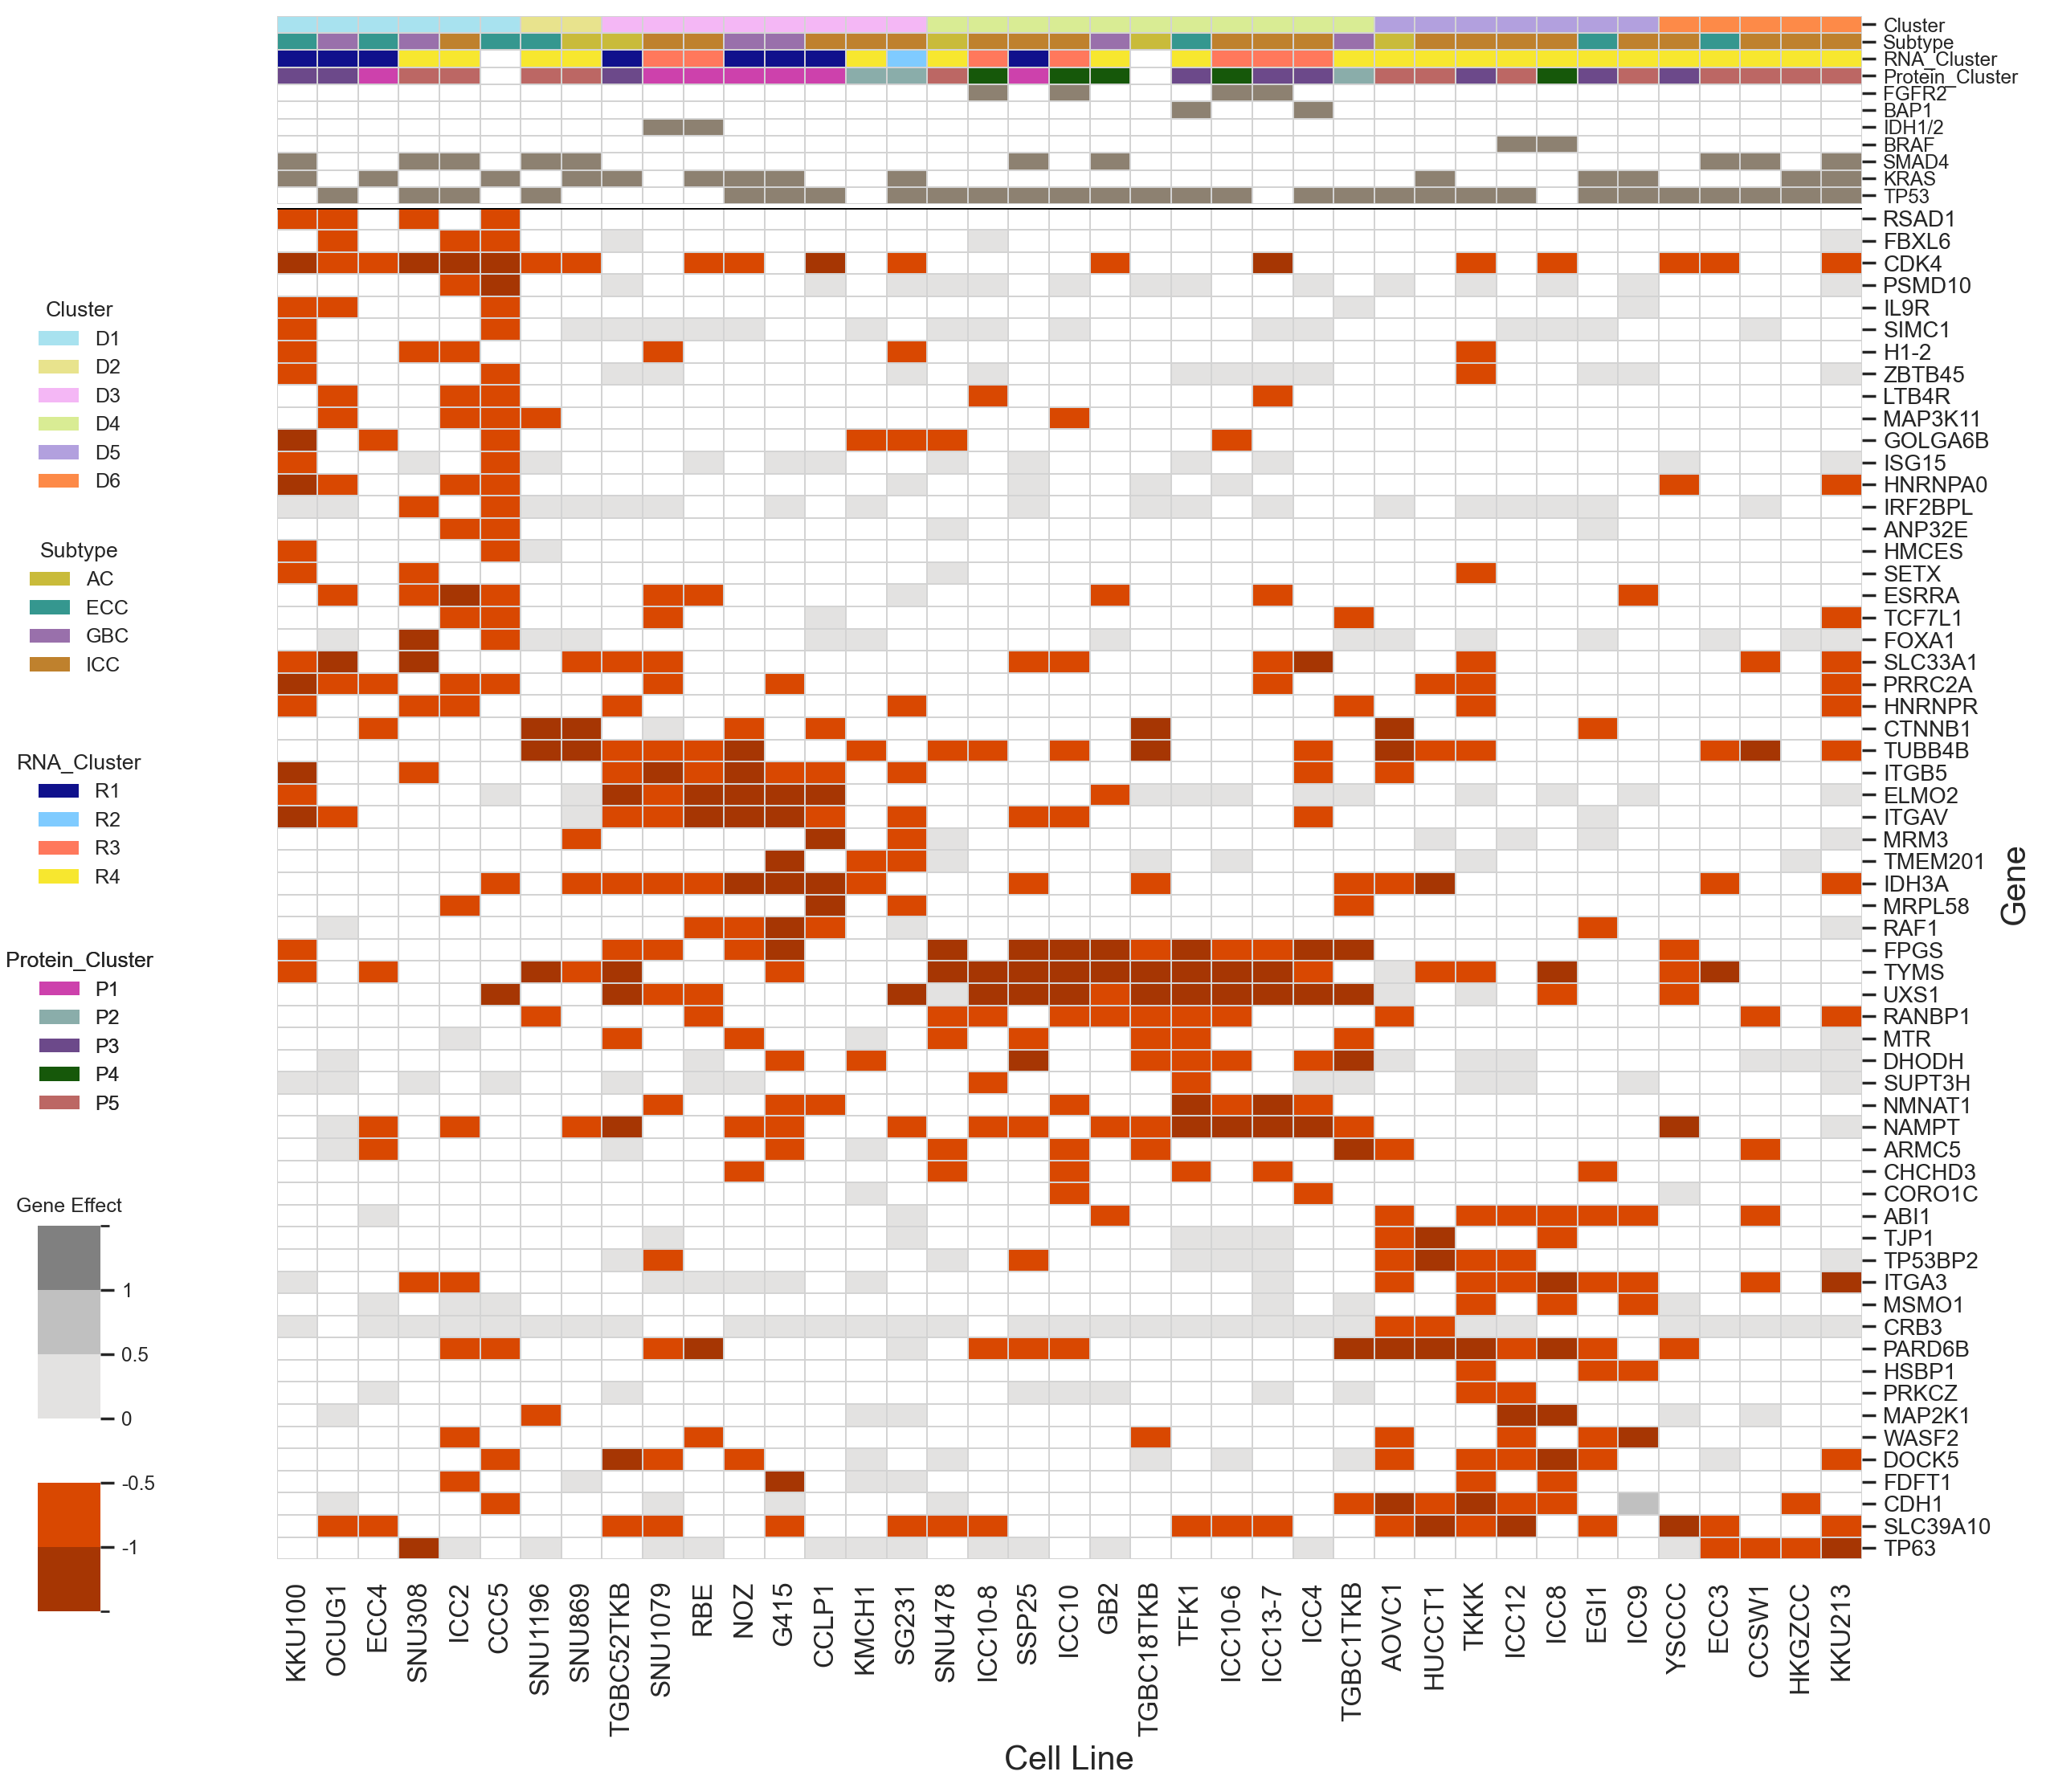

In [9]:
gammas = [1, 1.5, 2, 2.5, 3, 3.5] #

labels_np, consensus_ite = Clustering.louvain_clustering_ensemble(corr_gene_effect_lrt_filtered_df, gammas=gammas)
# up_markers_df, new_upset_df = Clustering.plot_consensus_heatmaps(gene_effect_lrt_filtered_df, corr_gene_effect_lrt_filtered_df, upset_mut_df, labels_np, consensus_ite, cluster_prefix='D', cbar_title='Gene Effect', row_label='Gene', up=False, ttest=True, q_val_thr=0.1, filter=True, row_cluster=False, event_legend = False, event_color='#8D0741', reverse=True, ytick_fontsize=10, xtick_fontsize=12, cbar_discrete=True, cbar_left_adjust=0.04, left_adjust=0.07, legend_top_offset=0.7, volcano_force_text=0.9, clusters_type_filename='LRT_')

clusters_reordering = [5, 1, 3, 2, 4, 6] # for visualization purposes reorder the clusters
up_markers_df, new_upset_df = Clustering.plot_consensus_heatmaps(gene_effect_lrt_filtered_df, corr_gene_effect_lrt_filtered_df, upset_mut_df, labels_np, consensus_ite, clusters_reordering=clusters_reordering, cluster_prefix='D', cbar_title='Gene Effect', row_label='Gene', up=False, ttest=True, q_val_thr=0.1, gene_effect_thr=-0.5, row_cluster=False, event_legend = False, event_color='#8D8171', reverse=True, ytick_fontsize=10, xtick_fontsize=12, cbar_discrete=True, cbar_left_adjust=0.04, left_adjust=0.07, legend_top_offset=0.7, volcano_force_text=.5, plot_volcano=True, clusters_type_filename='LRT_', volcano_axes_lim_dic=volcano_axes_lim_dic, cut_off_labels_top=20, filter=True, add_mean_cols=True, save_figure=True)

# ARI analysis

In [10]:
LRT_upset_file = 'Figure7/output_fig7/LRT_Gene_reordered_upset_df.csv'
LRT_upset_df = pd.read_csv(LRT_upset_file, index_col=0)

top_mut_file = 'Additional_Data/Selected_Lists/heatmap_top_alterations.csv'
top_mut_df = MyLib.load_csv(top_mut_file, index_col=0)
top_mut_df = top_mut_df.rename(columns={c:f'{c}$' for c in top_mut_df.columns.tolist()})
feat_df = top_mut_df.loc[LRT_upset_df.index, ]
feat_df.columns = [c.replace('$', '') for c in feat_df.columns]
feat_df = feat_df.fillna(0)

for f in feat_df.columns:
    feat_df[f] = feat_df[f].apply(lambda x:1 if x!=0 else 0)
for c in LRT_upset_df['Subtype'].unique():
    feat_df[c] = LRT_upset_df['Subtype'].apply(lambda x:1 if x==c else 0)
feats = ['BRAF', 'ERBB2','CDKN2A', 'EGFR', 'SMAD4','ARID1A', 'TP53',  'IDH1/2' , 'KRAS' ,'PBRM1' ,  'FGFR2',  'BAP1', 
'AC', 'ECC','GBC', 'ICC']
feat_df = feat_df[feats]
clusters_df = pd.DataFrame(0, index=LRT_upset_df.index, columns=sorted(LRT_upset_df['Cluster'].unique()))
for c in clusters_df.columns:
    clusters_df[c] = LRT_upset_df['Cluster'].apply(lambda x:1 if x==c else 0)

input_data/Additional_Data/Selected_Lists/heatmap_top_alterations.csv  is loaded, shape:  (87, 12)



D1
D2
D3
D4
D5
D6

File  Figure7/output_fig7/adjusted_rand_index_stats_CRISPR_clustering.csv saved, shape: (34, 6)

File  Figure7/output_fig7/adjusted_rand_scores_Clustering SimilaritiesCRISPR_clustering.csv saved, shape: (34, 6)


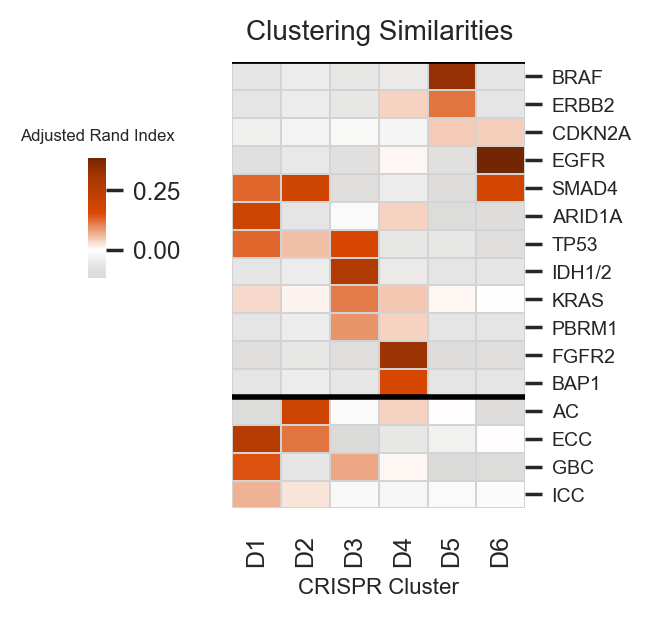

(            D1      D2      D3      D4      D5      D6
 BRAF       1.0     1.0     1.0     1.0   0.031     1.0
 ERBB2      1.0     1.0     1.0  0.4954  0.3302     1.0
 CDKN2A     1.0     1.0   0.686  0.8048  0.2404  0.2762
 EGFR       1.0     1.0     1.0  0.6448     1.0  0.0398
 SMAD4   0.1706  0.0608     1.0  0.8612     1.0  0.1038
 ARID1A  0.1598     1.0  0.6994  0.4482     1.0     1.0
 TP53    0.1578  0.4498  0.0922     1.0  0.8978     1.0
 IDH1/2     1.0     1.0  0.0336     1.0     1.0     1.0
 KRAS     0.363   0.596  0.0886  0.1266  0.5024  0.5946
 PBRM1      1.0     1.0  0.3808   0.479     1.0     1.0
 FGFR2      1.0     1.0     1.0  0.0048     1.0     1.0
 BAP1       1.0     1.0     1.0  0.0742     1.0     1.0
 AC         1.0  0.2372  0.7014   0.432  0.6598     1.0
 ECC      0.058  0.3256     1.0  0.9264  0.7804  0.6592
 GBC     0.2218     1.0  0.3576  0.5576     1.0     1.0
 ICC     0.0684  0.1976     1.0     1.0    0.68  0.6522,
               D1      D2      D3       D4     

In [11]:
# Clustering.clustering_scores(clusters_df, feat_df, split_row=[12], col_label='CRISPR Cluster', save_figure=True)
Clustering.clustering_scores_and_statistics(clusters_df, feat_df,  split_feats_l=['GBC', 'AC', 'ECC','ICC'],split_row=[12], col_label='CRISPR Cluster', save_figure=True, filename='CRISPR_clustering')

## ARI: Dependency clustering vs RNA and Proteomics clusterings

In [12]:
dep_upset_file = 'Figure7/output_fig7/LRT_Gene_reordered_upset_df.csv'
dep_upset_df = pd.read_csv(dep_upset_file, index_col=0)[['Cluster', 'Subtype', 'RNA_Cluster', 'Protein_Cluster']]

In [13]:
combined_clusters_df = clusters_df.copy()
combined_clusters_df['D5+D6'] = combined_clusters_df['D5'] + combined_clusters_df['D6']
dep_upset_df.replace('D5', 'D5+D6', inplace=True)
dep_upset_df.replace('D6', 'D5+D6', inplace=True)
dep_upset_df

,Cluster,Subtype,RNA_Cluster,Protein_Cluster
Cell_line,,,,
KKU100,D1,ECC,R1,P3
OCUG1,D1,GBC,R1,P3
ECC4,D1,ECC,R1,P1
SNU308,D1,GBC,R4,P5
ICC2,D1,ICC,R4,P5
CCC5,D1,ECC,NaN,NaN
SNU1196,D2,ECC,R4,P5
SNU869,D2,AC,R4,P5
TGBC52TKB,D3,AC,R1,P3


D1
D2
D3
D4
D5+D6

File  Figure7/output_fig7/adjusted_rand_index_stats_dep_rna_clustering_comparison_combined_D5_D6.csv saved, shape: (10, 5)

File  Figure7/output_fig7/adjusted_rand_scores_dep_rna_clustering_comparison_combined_D5_D6.csv saved, shape: (10, 5)


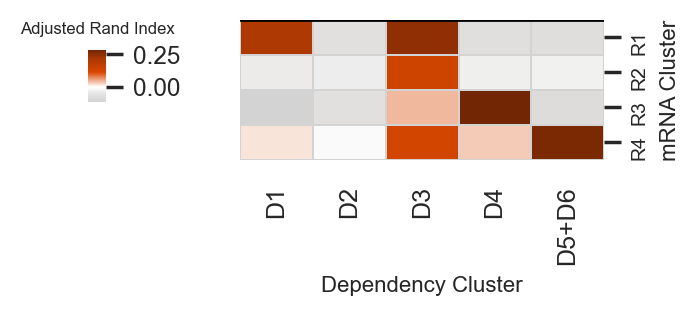

(        D1   D2      D3      D4   D5+D6
 R1  0.0916  1.0  0.0398  0.9502     1.0
 R2     1.0  1.0  0.2024     1.0     1.0
 R3     1.0  1.0   0.448   0.011     1.0
 R4   0.291  1.0  0.0124  0.1776  0.0006,
         D1   D2        D3        D4  D5+D6
 R1  0.3664  1.0     0.199       1.0    1.0
 R2     1.0  1.0  0.578286       1.0    1.0
 R3     1.0  1.0  0.995556  0.082667    1.0
 R4  0.7275  1.0  0.082667  0.578286  0.012)

In [14]:
dep_rna_upset_df = dep_upset_df[['RNA_Cluster']]
dep_rna_upset_df = dep_rna_upset_df.dropna(axis=0)
clusters_df2 = combined_clusters_df.loc[dep_upset_df.index, :][['D1', 'D2', 'D3', 'D4', 'D5+D6']]
rna_feat_df = pd.DataFrame(index=dep_upset_df.index)
for c in sorted(dep_rna_upset_df['RNA_Cluster'].unique()):
    rna_feat_df[c] = dep_upset_df['RNA_Cluster'].apply(lambda x:1 if x==c else 0)
Clustering.clustering_scores_and_statistics(clusters_df2, rna_feat_df, col_label='Dependency Cluster', row_label='mRNA Cluster', title='', figsize_w=3, figsize_h=1.3, save_figure=True, filename='dep_rna_clustering_comparison_combined_D5_D6')

D1
D2
D3
D4
D5+D6

File  Figure7/output_fig7/adjusted_rand_index_stats_dep_protein_clustering_comparison_combined_D5_D6.csv saved, shape: (12, 5)

File  Figure7/output_fig7/adjusted_rand_scores_dep_protein_clustering_comparison_combined_D5_D6.csv saved, shape: (12, 5)


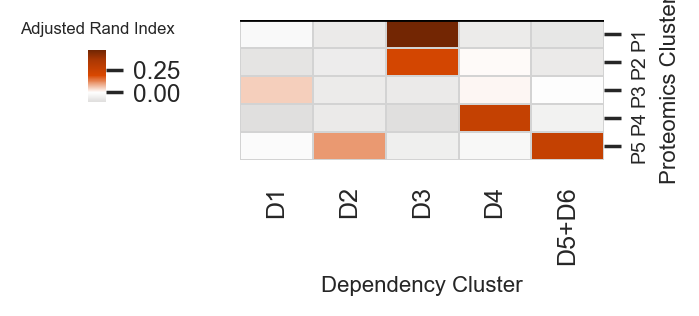

(        D1      D2      D3      D4   D5+D6
 P1  0.7288     1.0   0.002  0.9214     1.0
 P2     1.0     1.0  0.1092    0.65     1.0
 P3    0.42     1.0   0.901  0.4928  0.5858
 P4     1.0     1.0     1.0  0.0154  0.8634
 P5   0.661  0.1016  0.8618  0.5868   0.007,
      D1     D2     D3        D4   D5+D6
 P1  1.0    1.0   0.05       1.0     1.0
 P2  1.0    1.0  0.546       1.0     1.0
 P3  1.0    1.0    1.0       1.0     1.0
 P4  1.0    1.0    1.0  0.128333     1.0
 P5  1.0  0.546    1.0       1.0  0.0875)

In [15]:
dep_protein_upset_df = dep_upset_df[['Protein_Cluster']]
dep_protein_upset_df = dep_protein_upset_df.dropna(axis=0)
clusters_df2 = combined_clusters_df.loc[dep_upset_df.index, :][['D1', 'D2', 'D3', 'D4', 'D5+D6']]
protein_feat_df = pd.DataFrame(index=dep_upset_df.index)
for c in sorted(dep_protein_upset_df['Protein_Cluster'].unique()):
    protein_feat_df[c] = dep_upset_df['Protein_Cluster'].apply(lambda x:1 if x==c else 0)
Clustering.clustering_scores_and_statistics(clusters_df2, protein_feat_df, col_label='Dependency Cluster', row_label='Proteomics Cluster', title='', figsize_w=3, figsize_h=1.3, save_figure=True, filename='dep_protein_clustering_comparison_combined_D5_D6')

# Robustness Analysis

### Downsampling

In [16]:
# gene_effect_lrt_filtered_df2 = gene_effect_lrt_filtered_df.drop(['SNU1196', 'SNU869'], axis=0)
gene_effect_lrt_filtered_df2 = gene_effect_lrt_filtered_df
gene_effect_lrt_filtered_df2.shape

(39, 417)

In [17]:
gammas =  [1, 1.5, 2, 2.5, 3, 3.5]
sample_fractions_l = [.80, .75, .70, .65 , .60]
labels_dic = Clustering.run_louvain_on_multiple_subsamples(gene_effect_lrt_filtered_df2, gammas=gammas, sample_fractions_l=sample_fractions_l, filename='CRISPR')
# labels_dic = MyLib.load_pkl(f'Figure7/output_fig7/CRISPR_subsampling_labels_dic.pkl') # load saved results

started 50 runs with fraction 0.8
started 50 runs with fraction 0.75
started 50 runs with fraction 0.7
started 50 runs with fraction 0.65
started 50 runs with fraction 0.6

File  Figure7/output_fig7/CRISPR_subsampling_labels_dic.pkl saved, data size:  5



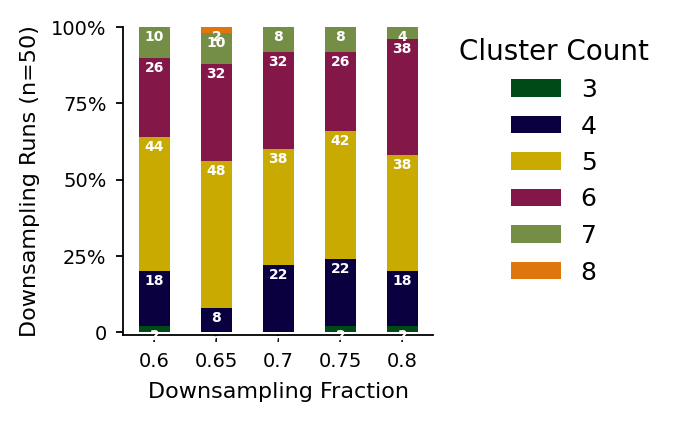

In [18]:
Clustering.louvain_clustering_stability_analysis(labels_dic, filename='CRISPR_Donwsampling')

<Figure size 400x200 with 0 Axes>

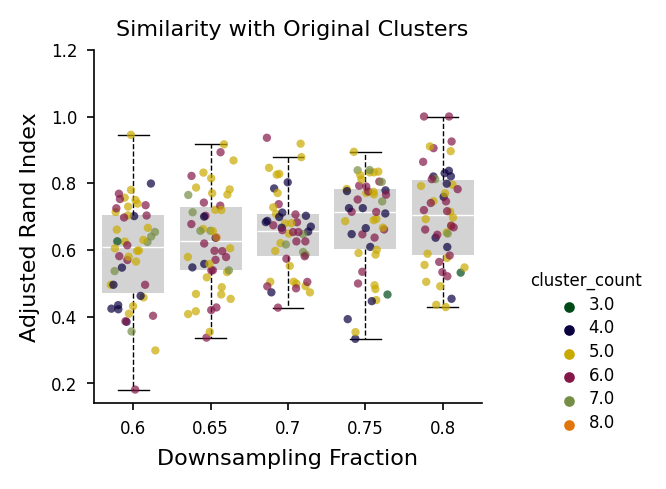

In [19]:
LRT_upset_file = 'Figure7/output_fig7/LRT_Gene_reordered_upset_df.csv'
LRT_upset_df = pd.read_csv(LRT_upset_file, index_col=0)
crispr_cluster_sr = LRT_upset_df['Cluster']
# crispr_cluster_sr = crispr_cluster_sr.drop(['SNU1196', 'SNU869'])

frac_color_dic = {frac:'lightgray' for frac in sorted(sample_fractions_l)}
Clustering.adjust_rand_index_downsampling_comparisons(crispr_cluster_sr, labels_dic, frac_color_dic, original_cluster_count=4,  ylim_top=1.2, filename='CRISPR_Donwsampling')

# Analyzing Differential Gene Expression Across Clusters

In [20]:
if new_upset_df is not None:
    LRT_upset_df = new_upset_df[['Cluster', 'Subtype']].copy()
else:
    LRT_upset_file = 'Figure7/output_fig7/LRT_Gene_reordered_upset_df.csv'
    LRT_upset_df = pd.read_csv(LRT_upset_file, index_col=0)

rna_counts_file = 'Main_Data/RNA/rna_cell_lines_expected_counts.csv'
rna_counts_df = MyLib.load_csv(rna_counts_file, index_col=0)
rna_counts_df.index = rna_counts_df.index.map(lambda c:c.split(' (')[0])

cells_l = sorted(set(LRT_upset_df.index).intersection(set(rna_counts_df.columns)))
LRT_upset_df = LRT_upset_df.loc[cells_l]
rna_counts_df = rna_counts_df[cells_l]

def drop_zero_or_constant_cols(df):
    columns_to_drop = []
    for col in df.columns:
        if (df[col] == 0).all() or df[col].nunique() == 1:
            columns_to_drop.append(col)
    df.drop(columns=columns_to_drop, inplace=True)
    return df
rna_counts_df = drop_zero_or_constant_cols(rna_counts_df.T).T

print(rna_counts_df.shape)

input_data/Main_Data/RNA/rna_cell_lines_expected_counts.csv  is loaded, shape:  (17852, 76)

(17761, 36)


In [21]:
LRT_upset_df['Cluster'].value_counts()

D4    9
D3    8
D5    7
D6    5
D1    5
D2    2
Name: Cluster, dtype: int64

## set data

In [22]:
data_type = 'mRNA_hits_'
data_df = rna_counts_df
exp_filter = True
data_df.shape

(17761, 36)

## D1

Number of cell lines in D1: 5


R[write to console]: Loading required package: usethis



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: data.table 1.14.8 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: **********
This installation of data.table has not detected OpenMP support. It should still work but in single-threaded mode.
This is a Mac. Please read https://mac.r-project.org/openmp/. Please engage with Apple and ask them for support. Check r-datatable.com for updates, and our Mac instructions here: https://github.com/Rdatatable/data.table/wiki/Installation. After several years of many reports of installation problems on Mac, it's time to gingerly point out that there have been no similar problems on Windows or Linux.
**********

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, first, last


R[wri

[1] "Number of genes:11919"


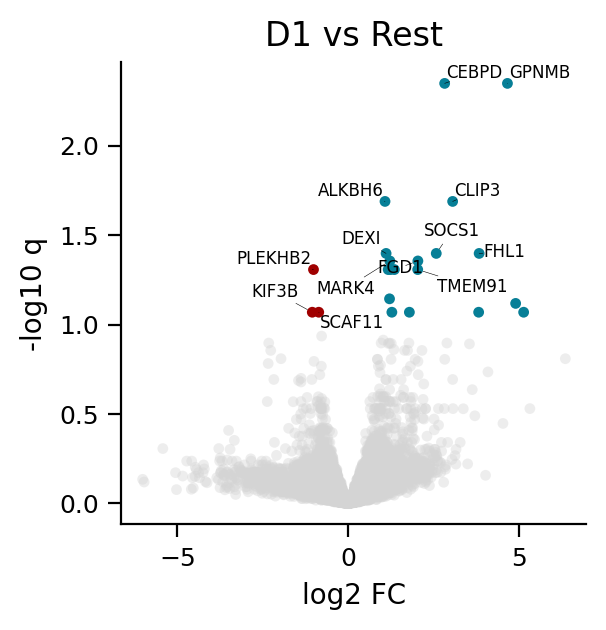


File  Figure7/output_fig7/mRNA_hits_D1_Rest_up.csv saved, shape: (19, 6)

File  Figure7/output_fig7/mRNA_hits_D1_Rest_down.csv saved, shape: (3, 6)


In [23]:
in_group = 'D1'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c1_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.5, file_name=data_type, return_up=True)

## D2

Number of cell lines in D2: 2
[1] "Number of genes:11919"


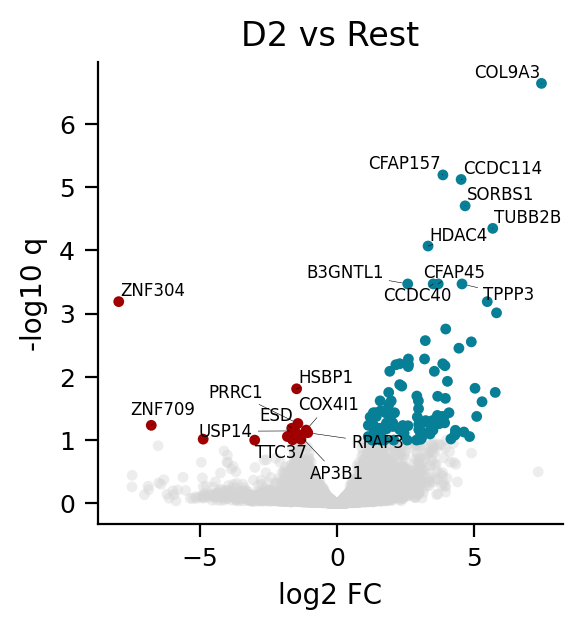


File  Figure7/output_fig7/mRNA_hits_D2_Rest_up.csv saved, shape: (108, 6)

File  Figure7/output_fig7/mRNA_hits_D2_Rest_down.csv saved, shape: (16, 6)


In [24]:
in_group = 'D2'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c2_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.5, file_name=data_type, return_up=True)

## D3

Number of cell lines in D3: 8
[1] "Number of genes:11919"


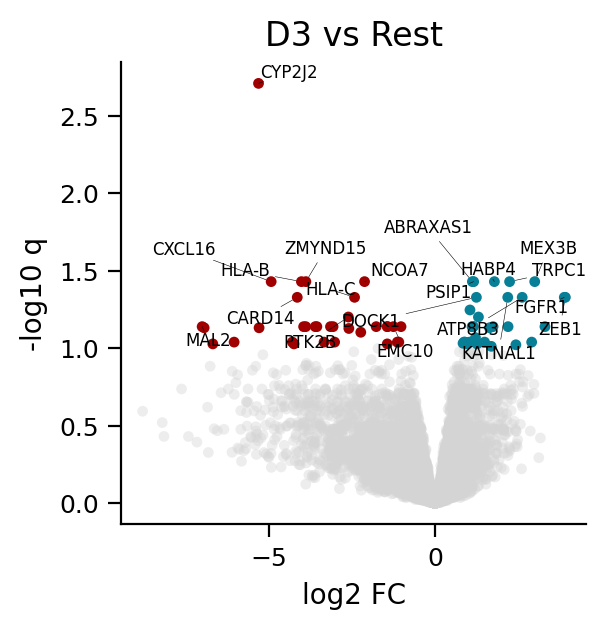


File  Figure7/output_fig7/mRNA_hits_D3_Rest_up.csv saved, shape: (32, 6)

File  Figure7/output_fig7/mRNA_hits_D3_Rest_down.csv saved, shape: (33, 6)


In [25]:
in_group = 'D3'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c3_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.3, force_points=.3, file_name=data_type, return_up=True)


 ## D4

Number of cell lines in D4: 9
[1] "Number of genes:11919"


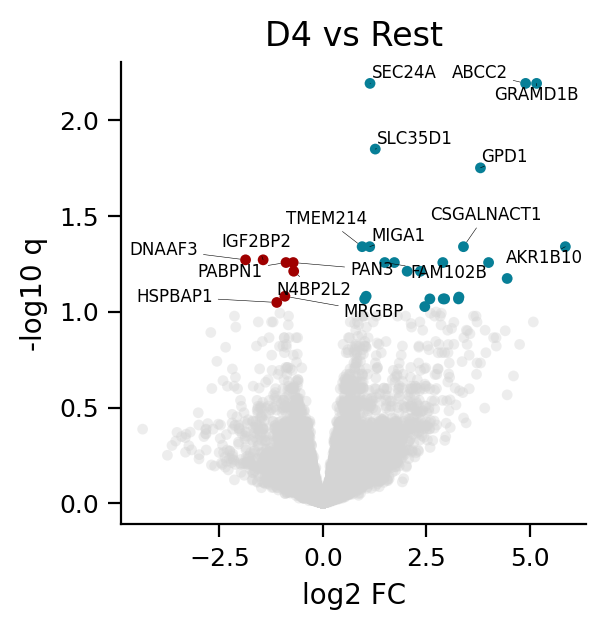


File  Figure7/output_fig7/mRNA_hits_D4_Rest_up.csv saved, shape: (24, 6)

File  Figure7/output_fig7/mRNA_hits_D4_Rest_down.csv saved, shape: (7, 6)


In [26]:
in_group = 'D4'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c4_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.5, file_name=data_type, return_up=True)

## D5

Number of cell lines in D5: 7
[1] "Number of genes:11919"


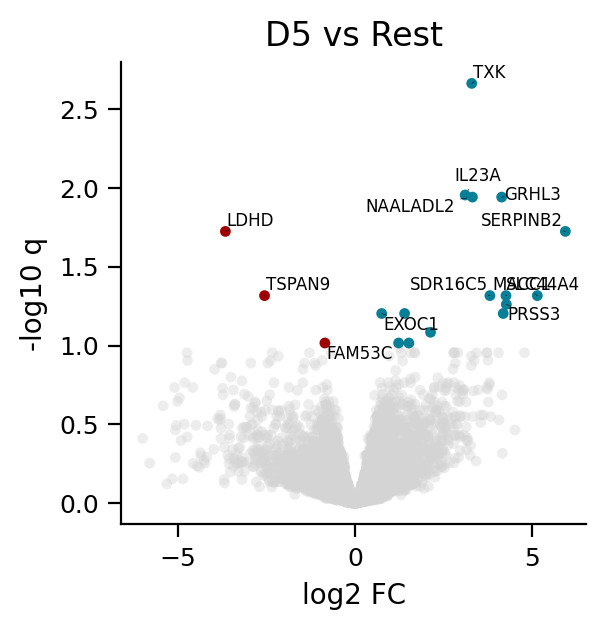


File  Figure7/output_fig7/mRNA_hits_D5_Rest_up.csv saved, shape: (15, 6)

File  Figure7/output_fig7/mRNA_hits_D5_Rest_down.csv saved, shape: (3, 6)


In [27]:
in_group = 'D5'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c5_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.5, file_name=data_type, return_up=True)

## D6

Number of cell lines in D6: 5
[1] "Number of genes:11919"


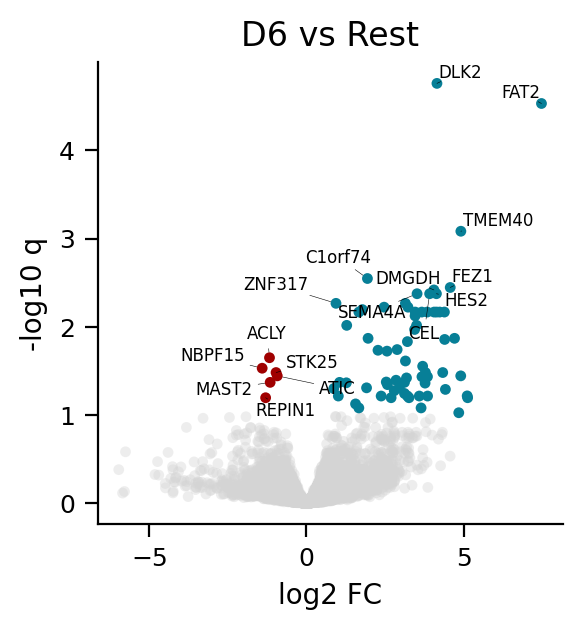


File  Figure7/output_fig7/mRNA_hits_D6_Rest_up.csv saved, shape: (67, 6)

File  Figure7/output_fig7/mRNA_hits_D6_Rest_down.csv saved, shape: (6, 6)


In [28]:
in_group = 'D6'
design_df = MyRFunctions.create_design_table(LRT_upset_df, in_group, group_col='Cluster')
print(f'Number of cell lines in {in_group}:', design_df['In'].sum())
res_df = MyRFunctions.limma_de(data_df, design_df, plot_path=os.path.join(io_library.output_dir, f'mrna_{in_group}_OtherBTC_limma.jpeg'), exp_filter=exp_filter)
c6_up_df = Utils.visualize_de_genes(res_df, in_group, pval_col='P.Value', fdr_col='adj.P.Val', force_text=.5, file_name=data_type, return_up=True)